# Physics-Informed Neural Network Tutorial Example
***
### Adapted from Nascimento et al. 2020, _A tutorial on solving ordinary differential equations using Python and hybrid physics-informed neural network_, https://doi.org/10.1016/j.engappai.2020.103996
### Original code from Fricke et al. 2020, _Python Implementation of Ordinary Differential Equations Solvers using Hybrid Physics-informed Neural Networks_, https://github.com/PML-UCF/pinn_ode_tutorial
### Adapted for Jupyter Notebook by Benjamin Morris, 2022
***

This tutorial shows how to create a hybrid physics-informed neural network (PINN) for solving ordinary differential equations (ODE). Additional detail is found in Nascimento et al.'s original 2020 paper.

## Setup
### (Packages, Functions)
<br>
This section deals with importing required packages and defining functions. This includes setting up the network architecture and defining all relevant equations.

Import dependencies. In my case (Intel Macbook Pro 2017, MacOS Monterey V12.3), there is an issue where importing PyTorch/Tensorflow packages after Pandas and NumPy causes an issue. Importing ML packages first seems to resolve this issue.

In [1]:
from torch.nn.parameter import Parameter
from torch import (
    linalg,
    nn,
    Tensor,
    stack,
    cat,
    transpose,
    optim,
    zeros,
    diag
    )

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as matplotlib


Define Recurrent Neural Network (RNN) architecture. The RNN implemented here is a specialized RNN architecture that implements numerical integration directly (via the RK cell class below).

In [2]:
class MyRNN(nn.Module):
    def __init__(self, cell, **kwargs):
        super(MyRNN, self).__init__()
        self.cell = cell

    def forward(self, inputs, initial_state):

        bs, seq_sz, _ = inputs.shape
        state = []
        state.append(initial_state)
        for t in range(1, seq_sz): 
            input = inputs[:, t-1, :]
            state_t = self.cell.forward(input, state[t-1])
            state.append(state[t-1]+state_t)

        return stack((state),dim=1)
    

Define a Runge-Kutta integrator cell (RK4). It is possible that RK5 would give higher accuracy (at higher computational cost), but RK4 is sufficient for this example. However, RK45 would not be possible since the RK45 algorithm involves a logic gate, which cannot be converted to a neural architecture.

Note that the damping matrix [C] is defined in the forward method of the RK integrator class, unlike the mass or stiffness matrix. **This allows [C] to be tuned during training**, thus makes this method suitable for system ID problems.

In [3]:
class RungeKuttaIntegratorCell(nn.Module):
    def __init__(self, m, c, k, dt, **kwargs):
        super(RungeKuttaIntegratorCell, self).__init__(**kwargs)
        self.Minv = linalg.inv(diag(m))
        self.c1 = Parameter(c[0])
        self.c2 = Parameter(c[1])
        self.c3 = Parameter(c[2])
        
        self.K    = Tensor([[k[0]+k[1],-k[1]],[-k[1],k[1]+k[2]]])
        self.state_size    = 2*len(m)
        self.A  = Tensor([0., 0.5, 0.5, 1.0])
        self.B  = Tensor([[1/6, 2/6, 2/6, 1/6]])
        self.dt = dt
        
    def forward(self, inputs, states):
        C = stack((stack((self.c1+self.c2, -self.c2)), stack((-self.c2, self.c2+self.c3))))
        y    = states[:, :2]
        ydot = states[:, 2:]
        
        yddoti = self._fun(self.Minv, self.K, C, inputs, y, ydot)
        yi     = y + self.A[0] * ydot * self.dt
        ydoti  = ydot + self.A[0] * yddoti * self.dt
        fn     = self._fun(self.Minv, self.K, C, inputs, yi, ydoti)
        for j in range(1,4):
            yn    = y + self.A[j] * ydot * self.dt
            ydotn = ydot + self.A[j] * yddoti * self.dt
            ydoti = cat([ydoti, ydotn], dim=0)
            fn    = cat([fn, self._fun(self.Minv, self.K, C, inputs, yn, ydotn)], dim=0)

        y    = linalg.matmul(self.B, ydoti) * self.dt
        ydot =  linalg.matmul(self.B, fn) * self.dt

        return cat(([y, ydot]), dim=-1)

    def _fun(self, Minv, K, C, u, y, ydot):
        return linalg.matmul(u - linalg.matmul(ydot, transpose(C, 0, 1)) - linalg.matmul(y, transpose (K, 0, 1)), transpose(Minv, 0, 1))



Define training loop. This function just consolidates the usual forward->loss->back propogation->optimization scheme for readability.

Along with the loss function (specified as MSE later), another L1 error metric (i.e., mean absolute error, MAE) is defined and tracked, but not used for training. The MAE simply gives another error metric to look at alongside MSE.

In [4]:
def pinn_training_loop(n_epochs, optimizer, model, loss_fn, train, label, initial_state):
    mae = nn.L1Loss()
    for epoch in range(1, n_epochs + 1):
        #Forward pass
        output_train = model(train, initial_state)[:, :, :2]
        loss_train = loss_fn(output_train, label)
        mae_train = mae(output_train, label)

        #Backward pass
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        print(f"Epoch {epoch}, Training loss {loss_train.item():.4e}, mae {mae_train.item():.4e}")
        

## Execution
### (Training, Testing, Plotting)
<br>
This section implements the actual training and testing algorithms, as well as any plotting.

Define system matrices [M], [C], and [K]. This tutorial describes a 2DOF spring-mass-damper system coupled to rigid walls on either side.

<img src="images/2DOF_system.png" alt="2DOF spring-mass-damper system" width="300"/>

In [5]:
if __name__ == "__main__":
    # masses, spring coefficients, and damping coefficients
    m = Tensor([20.0, 10.0])
    k = Tensor([2e3, 1e3, 5e3])
    c = Tensor([10.0, 10.0, 10.0]) # initial guess for damping coefficient
    

Import training data

In [6]:
    # data
    df = pd.read_csv('./data/data.csv')
    t  = df[['t']].values
    dt = (t[1] - t[0])[0]
    utrain = df[['u0', 'u1']].values[np.newaxis, :, :]
    ytrain = df[['yT0', 'yT1']].values[np.newaxis, :, :]
    t = Tensor(t)
    utrain = Tensor(utrain)
    ytrain = Tensor(ytrain)
    

Initialize the system at rest

In [7]:
    # Initial state of the system 
    initial_state = zeros((1,2 * len(m)))
    print(initial_state)
    

tensor([[0., 0., 0., 0.]])


Build network architecture using the RK cell. Passing the RK cell to MyRNN() allows the RK cell to be used like a typical RNN architecture (I think). Use the initial model to predict the response before training.

In [8]:
    rkCell = RungeKuttaIntegratorCell(m=m, c=c, k=k, dt=dt)
    model = MyRNN(cell=rkCell)
    
    #prediction results before training
    yPred_before = model(utrain, initial_state)[0, :, :]
    yPred_before = yPred_before.detach().numpy()[:,:2]
    

Train the model using the pinn_training_loop() function. Make a prediction of the response after training.

In [9]:
    #PINN training
    pinn_training_loop(
        n_epochs = 100,
        optimizer = optim.RMSprop(model.parameters(), lr=1e4),
        model = model,
        loss_fn = nn.MSELoss(),
        train = utrain,
        label = ytrain,
        initial_state=initial_state
        )

    #prediction results after training
    yPred = model(utrain, initial_state) [0, :, :]
    yPred = yPred.detach().numpy()[:,:2]
    

Epoch 1, Training loss 1.1535e-08, mae 7.9121e-05
Epoch 2, Training loss 3.1196e-09, mae 2.8909e-05
Epoch 3, Training loss 3.0777e-09, mae 2.8707e-05
Epoch 4, Training loss 3.0358e-09, mae 2.8505e-05
Epoch 5, Training loss 2.9939e-09, mae 2.8306e-05
Epoch 6, Training loss 2.9520e-09, mae 2.8108e-05
Epoch 7, Training loss 2.9102e-09, mae 2.7912e-05
Epoch 8, Training loss 2.8684e-09, mae 2.7719e-05
Epoch 9, Training loss 2.8266e-09, mae 2.7527e-05
Epoch 10, Training loss 2.7848e-09, mae 2.7338e-05
Epoch 11, Training loss 2.7431e-09, mae 2.7151e-05
Epoch 12, Training loss 2.7014e-09, mae 2.6964e-05
Epoch 13, Training loss 2.6597e-09, mae 2.6778e-05
Epoch 14, Training loss 2.6180e-09, mae 2.6592e-05
Epoch 15, Training loss 2.5764e-09, mae 2.6408e-05
Epoch 16, Training loss 2.5348e-09, mae 2.6226e-05
Epoch 17, Training loss 2.4932e-09, mae 2.6044e-05
Epoch 18, Training loss 2.4517e-09, mae 2.5862e-05
Epoch 19, Training loss 2.4102e-09, mae 2.5681e-05
Epoch 20, Training loss 2.3688e-09, mae 

Plot the pre-trained (red), post-trained (blue), and noisy training data (grey) on the same plot for comparison purposes.

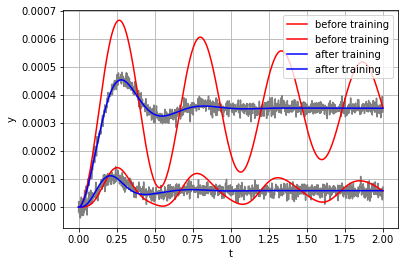

In [10]:
    # plotting prediction results
    plt.plot(t, ytrain[0, :, :], 'gray')
    plt.plot(t, yPred_before, 'r', label='before training')
    plt.plot(t, yPred, 'b', label='after training')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.grid('on')
    plt.legend()
    plt.show()
